# Import

In [1]:
import os
import numpy as np

from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import lightkurve as lk
from astroquery.simbad import Simbad
import pandas as pd 
from numpy import genfromtxt
from sklearn.preprocessing import normalize

from labellines import labelLine, labelLines


# #tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



## Check GPU

In [2]:
devices = tf.config.list_physical_devices()
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Data

In [3]:
pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/Data_v4/0.csv',delimiter=',').to_numpy().shape

(122, 244)

In [4]:
# low_teff = True
# low_teff_err = pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/Labels/Teff_err.csv',delimiter=',').to_numpy().T[1].T
# print(low_teff_err)

In [5]:
all_data = np.empty((1,243))
for dataset in ['Data_v4']:
  new_data = np.empty((1,244))
  for i in range(1610*2):
    try:
      new_data = np.concatenate((new_data,pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/'+dataset+'/'+str(i)+'.csv',delimiter=',').to_numpy()), axis=0)
    except:
      continue
    print("\r"+str(i),end="")
  new_data = new_data[1:].T[1:].T
  print(new_data.shape)
  all_data = np.concatenate((all_data,new_data),axis=0)
all_data = all_data[1:]
print(all_data.shape)

1609(214942, 243)
(214942, 243)


In [6]:
print(all_data)
print(all_data.T[1])

[[7.57137000e+05 4.75100000e+03 1.39000000e+02 ... 2.84220046e-01
  1.98787545e-01 3.52143589e-01]
 [7.57137000e+05 4.75100000e+03 1.39000000e+02 ... 9.00410425e-02
  2.38116041e-01 1.33820551e-01]
 [7.57137000e+05 4.75100000e+03 1.39000000e+02 ... 6.99888643e-02
  1.28790969e-01 2.76750793e-01]
 ...
 [1.29345740e+07 4.83400000e+03 1.43000000e+02 ... 2.39368800e-01
  1.34656354e-01 3.30117909e-01]
 [1.29345740e+07 4.83400000e+03 1.43000000e+02 ... 5.32880594e-01
  1.53275869e-01 1.18398710e+00]
 [1.29345740e+07 4.83400000e+03 1.43000000e+02 ... 2.38655505e-01
  4.39093700e-01 9.84966052e-01]]
[4751. 4751. 4751. ... 4834. 4834. 4834.]


In [7]:
def isolate_observations(data):
    kic = 0
    res = np.empty((1,474))
    for i in range(len(data)):
        if(data[i][0]!=kic):
            kic = data[i][0]
            res = np.vstack((res,data[i]))
    return res

# iso_data = isolate_observations(all_data).T[:10].T
# print(iso_data)

In [8]:
def extract_xy(all_data):
    all_x = all_data.T[7:243].T
    all_y = all_data.T[1:7].T
    print(all_x.shape,all_y.shape)
    teff_y = all_y.T[2:4].T
    print(teff_y.shape)
    print(teff_y)
    print(all_x[0])
    return all_x,teff_y

all_x,teff_y = extract_xy(all_data)

(214942, 236) (214942, 6)
(214942, 2)
[[2.383 0.012]
 [2.383 0.012]
 [2.383 0.012]
 ...
 [2.387 0.012]
 [2.387 0.012]
 [2.387 0.012]]
[ 0.         13.16467881 11.85662574  5.37137053  2.34753016  7.56242166
  7.09166395  8.9345866   4.47222976  5.44573758  7.99705157  6.5553589
  7.43230342  2.14978082  6.70502292  2.11453161  1.47941903  3.4679212
  0.95694623  6.41945024 13.71684545  2.6618294   6.7777871   4.03523607
  1.65132679  1.22634052  2.47702523  1.62667739  2.94700681  2.16647403
  0.86192238  1.94095918  1.36412959  1.50011758  1.52687553  0.3987771
  0.26511563  1.70271956  2.16544294  1.24192005  0.74680304  1.26339405
  2.43964765  0.62723454  1.35998087  0.3313366   0.39359298  0.8410012
  0.59152181  0.47106868  1.50347768  1.05735322  0.37600592  1.01079496
  0.06908752  1.03337513  0.57106625  0.72521993  0.70155079  0.43960006
  1.06916899  1.62702797  0.75722071  0.81743033  0.08991218  0.78076904
  0.58342839  0.82547409  1.41460742  0.44502772  0.51703072  0.164

In [9]:
def normalize_with_moments(X_train, axes=0, epsilon=1e-8,keep_dims=True):
    x = tf.convert_to_tensor(X_train)
    mean, variance = tf.nn.moments(x, axes=axes)
    x_normed = (x - mean) / tf.sqrt(variance + epsilon) # epsilon to avoid dividing by zero
    return x_normed

def normalize_x(x):
    x = x.T
    for i in range(len(x)):
        x[i] = x[i] / np.linalg.norm(x[i])
    return x.T

In [10]:
# teff_y = normalize_with_moments(teff_y).numpy()
# all_x = normalize_x(all_x)
# print(teff_y)
# print(all_x)

In [11]:
print(all_x[1])

[ 1.          8.43454255  3.81606884  5.60029841  4.00062612  1.87763442
  6.60502431  1.75453517  2.03889624  2.15967502  6.61839709 10.96603738
  1.00941128 11.83732916  6.832062    2.11275395  0.68517313  2.80103935
  3.12226637  2.10477594  6.60518561  0.61505648  2.00240753  3.97648499
  1.3740333   1.3024308   2.02690753  1.48491184  1.63691857  1.22361546
  2.55480434  1.85227138  0.76009708  0.77010233  0.35528595  1.09636679
  0.89292322  1.34251061  0.63681166  0.43798736  1.08026908  0.28756933
  0.23743421  0.18253782  0.52691456  0.34023662  0.32434848  0.73180473
  0.15601266  0.71085421  0.67786938  0.25223334  0.57520825  0.52608914
  0.17351905  0.61305125  0.5747885   0.35867008  0.50785905  0.28822274
  0.18542083  0.72036011  0.74996212  0.78635087  0.37852229  0.35192467
  0.29241703  0.1940635   0.62021354  0.59715896  0.32950041  0.48906543
  0.57471503  0.23230492  0.60162748  0.24766141  0.32702928  0.24256991
  0.30468094  0.40705864  0.32715655  0.47648729  0

# Machine Learning

In [12]:
train_x,test_x,train_y,test_y=train_test_split(all_x, teff_y, test_size=0.20, random_state=42)
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)
train_x = np.asarray(train_x).astype('float32')
test_x = np.asarray(test_x).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

# # Convolutional
# train_x = train_x[..., None]
# test_x = test_x[..., None]
# train_y = train_y[..., None]
# test_y = test_y[..., None]
# print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

(171953, 236) (42989, 236) (171953, 2) (42989, 2)
(171953, 236) (42989, 236) (171953, 2) (42989, 2)


In [13]:
tf.test.gpu_device_name() # No GPU Sad :v
# tf.config.optimizer.set_jit(True)
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()
model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))

#model.add(layers.Embedding(input_dim=64, output_dim=16))
#model.add(layers.LSTM(128,dr
# opout=0.2,recurrent_dropout=0.2,input_dim=(train_x.shape[2])))
#model.add(layers.Conv1D(1024,1,activation='relu',input_shape=(train_x.shape)))
#model.add(layers.Conv1D(256,1,activation='relu'))
model.add(layers.Dense(2048, activation="relu", input_shape=((236,))))
# model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu', input_shape=(236,1)))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=32, kernel_size=4, activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
# model.add(layers.Dense(32, activation="relu"))
# model.add(layers.Dense(4, activation="relu"))
# model.add(layers.Dense(1, activation="relu"))
model.add(layers.Dense(2))
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              485376    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
________________________________________

2022-02-01 23:00:20.677825: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-01 23:00:20.678534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-01 23:00:20.691275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-01 23:00:20.691292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)
monitor = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, 
        patience=20, verbose=1, mode='auto',
        restore_best_weights=True)

# def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('loss') <= 15000):
#         print("\n\n\nReached 0.05 loss value so cancelling training!\n\n\n")
#         model.stop_training = True


# trainingStopCallback = on_epoch_end()


In [15]:
history = model.fit(train_x, train_y, epochs=1000,validation_data=(test_x, test_y),callbacks=[monitor], verbose=2)
# history = model.fit(train_x, train_y, epochs=150,validation_data=(test_x, test_y), verbose=2)

2022-02-01 23:01:52.014151: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-01 23:01:52.018548: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-01 23:01:52.170289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/1000


2022-02-01 23:02:31.374538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5374/5374 - 44s - loss: 0.0190 - accuracy: 0.9996 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 2/1000
5374/5374 - 44s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 3/1000
5374/5374 - 44s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 4/1000
5374/5374 - 46s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 5/1000
5374/5374 - 47s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 6/1000
5374/5374 - 46s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 7/1000
5374/5374 - 47s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 8/1000
5374/5374 - 47s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 9/1000
5374/5374 - 46s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 10/1000
5374/5374 - 46s - loss: 0.0023 - accuracy: 1.0000 - va

In [16]:
model.save('/Users/michaelsong/Documents/GitHub/starzam/Models/g_2_1')

2022-02-01 23:27:17.892554: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/michaelsong/Documents/GitHub/starzam/Models/g_2_1/assets


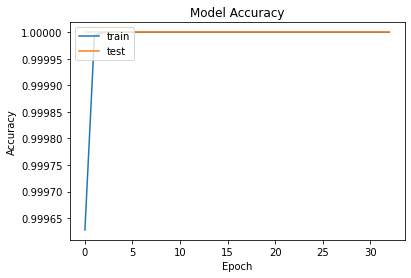

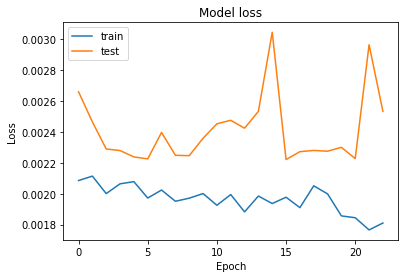

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/2m.2_training.png')
plt.show()

In [39]:
# model = tf.keras.models.load_model('/Users/michaelsong/Documents/GitHub/starzam/Models/2m.1')

# # Check its architecture
# model.summary()

In [40]:
weights = model.get_weights()
print(weights[1])
print(weights[2])
print(weights[3])
print(np.where(weights[0] > 0))
print(weights[0][26:150])

[0.32018605 1.289327   0.01712296 ... 0.37543136 1.4247496  0.41750863]
[[ 0.0006773  -0.00059883 -0.04183141 ...  0.02173682 -0.03228121
  -0.00808503]
 [-0.02579501  0.02654243 -0.02853735 ... -0.0490011   0.02505797
  -0.01587518]
 [ 0.0221907  -0.04054452 -0.03844791 ... -0.01323212 -0.00539195
  -0.01103589]
 ...
 [ 0.00082879 -0.04398068 -0.00165969 ...  0.01708967  0.01731969
   0.03022519]
 [-0.01287024 -0.00509336 -0.00638997 ...  0.00917217 -0.04342896
  -0.03780835]
 [ 0.00868471 -0.00740309 -0.04148255 ...  0.03698791 -0.04789698
   0.01785865]]
[ 0.6404638  -0.03777128 -0.03511848 ... -0.00811189 -0.00496501
 -0.00426894]
(array([  0,   0,   0, ..., 235, 235, 235]), array([   3,   11,   15, ..., 2034, 2043, 2046]))
[[-0.04790043 -0.13820174 -0.00547263 ... -0.08290405  0.191638
  -0.10654034]
 [-0.03648783 -0.16245832 -0.04123789 ... -0.0534941   0.317138
  -0.01227977]
 [-0.03835787 -0.20475705  0.01510645 ... -0.02377557 -0.67098415
  -0.03021021]
 ...
 [ 0.02942203 -0.1

ValueError: x and y must have same first dimension, but have shapes (236,) and (55696,)

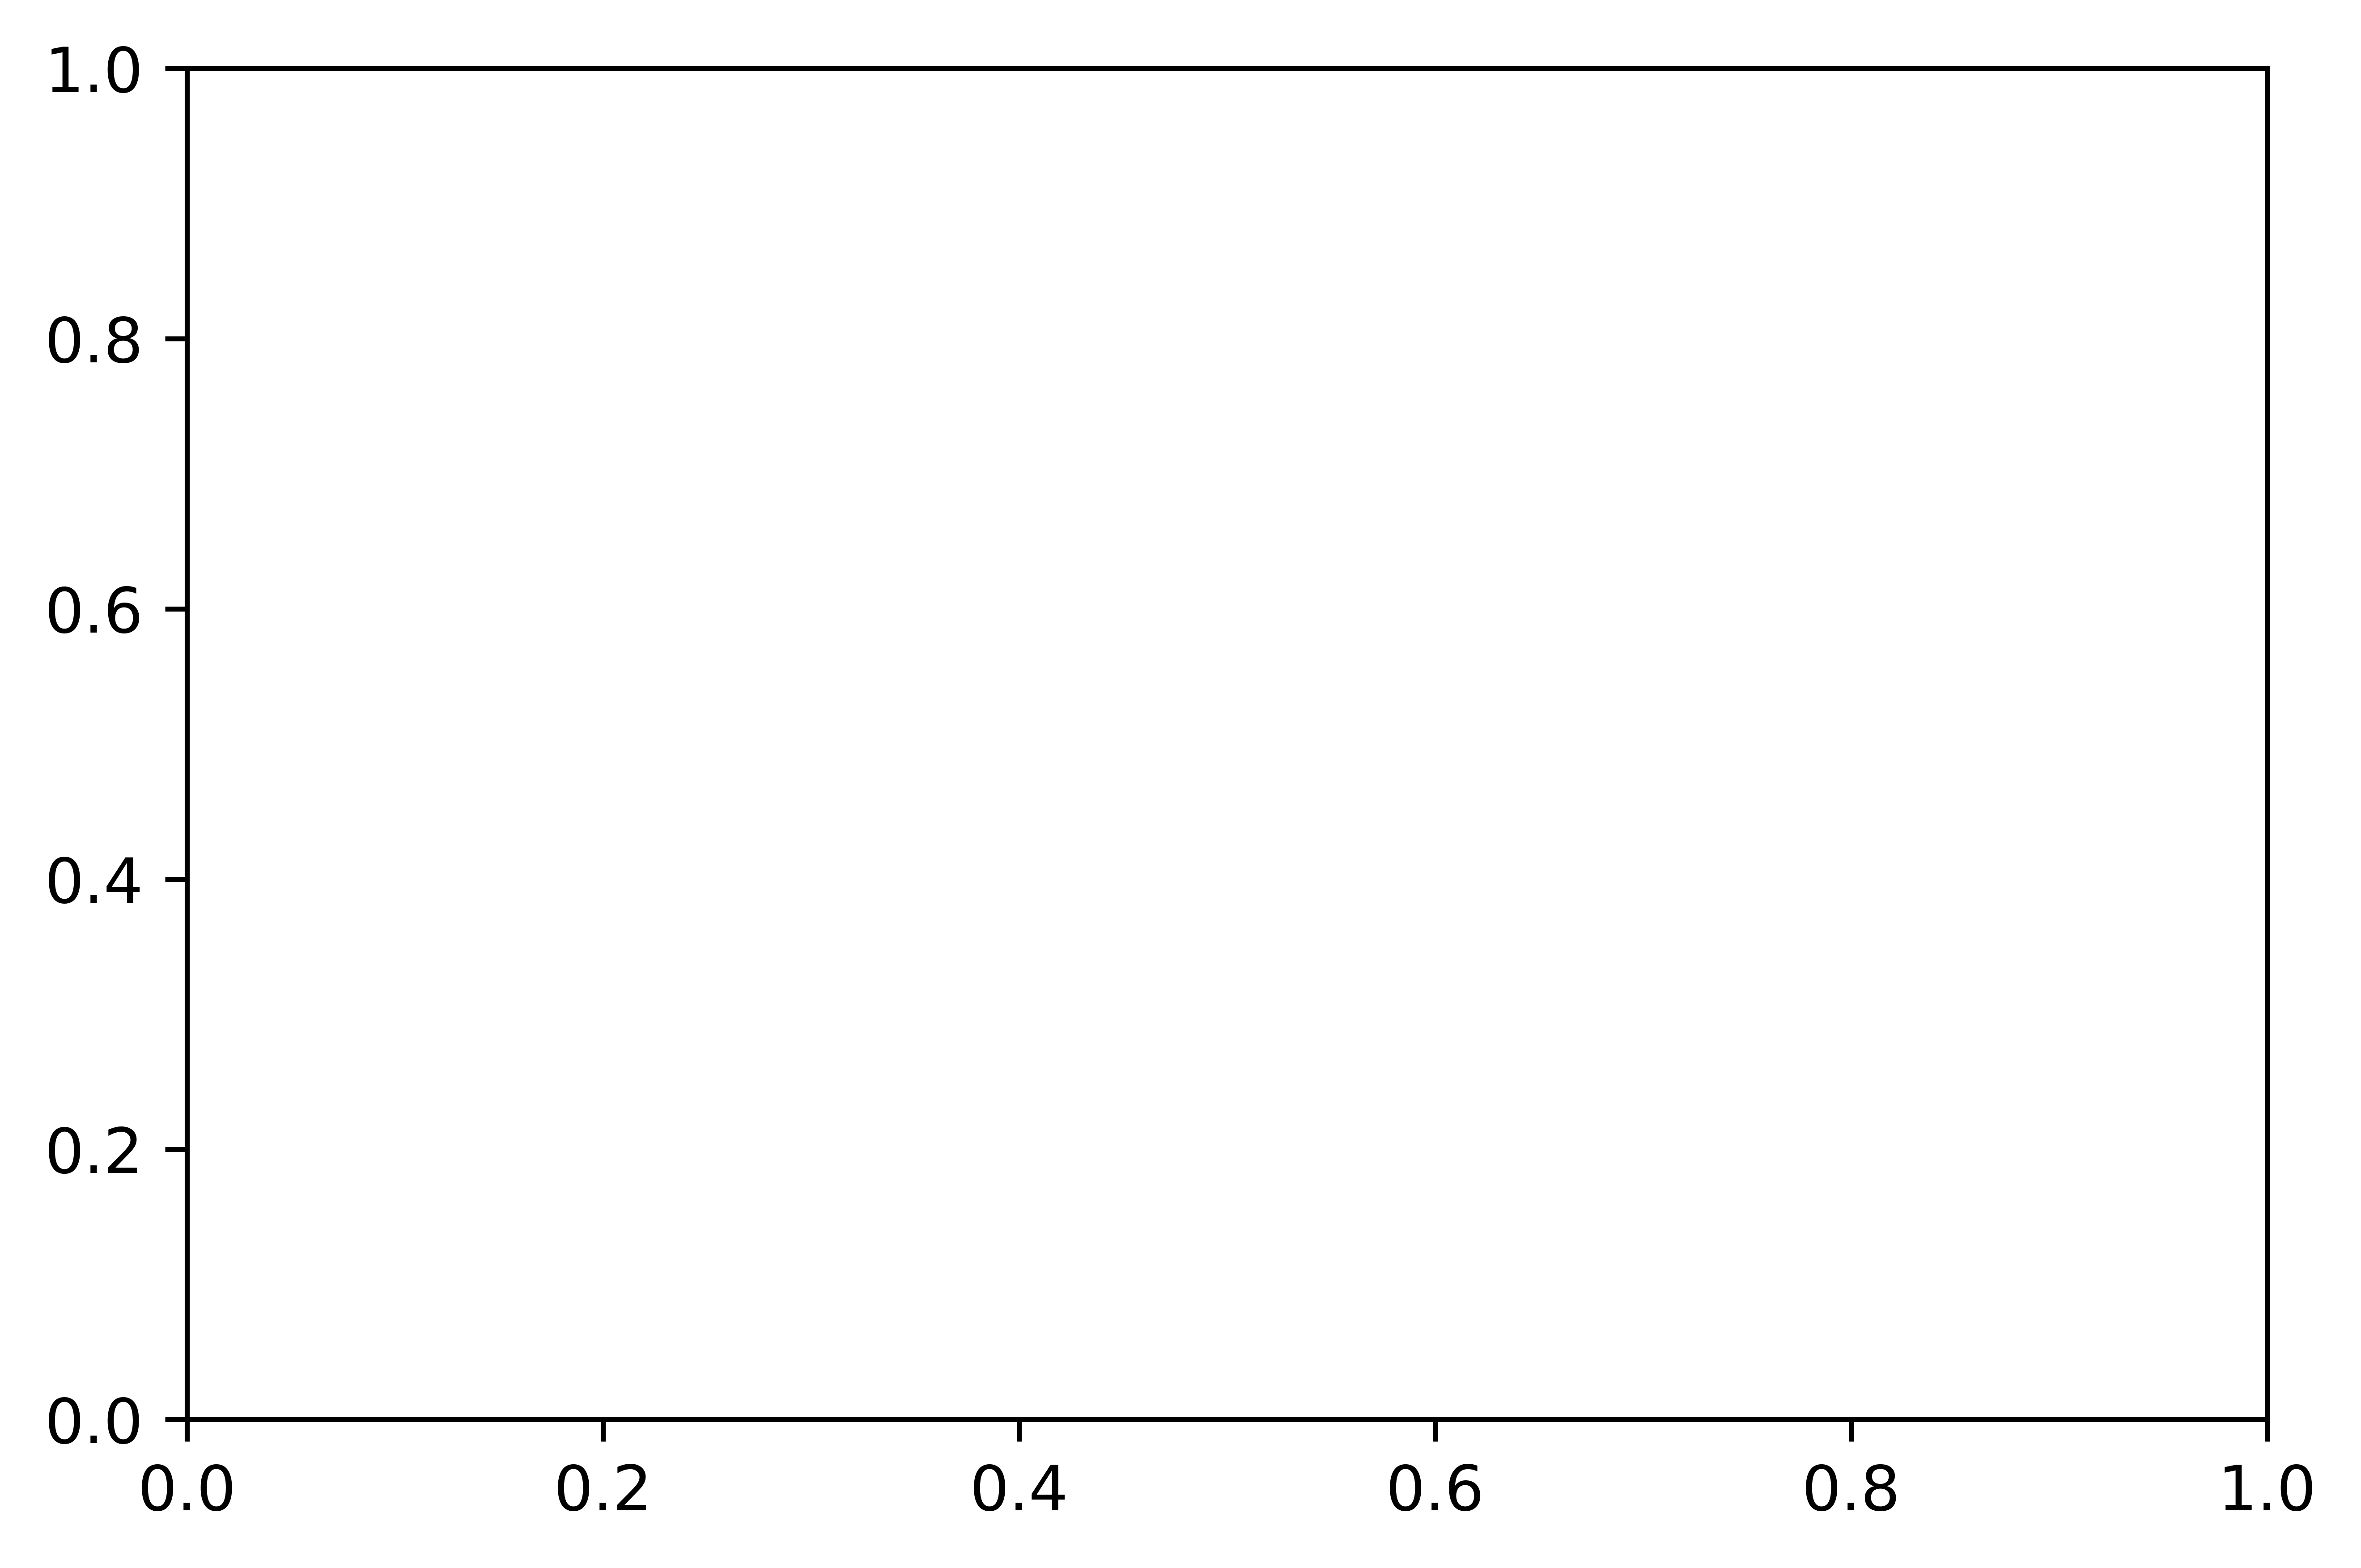

In [16]:
plt.rcParams['figure.dpi'] = 1000
# plt.figure(figsize = (6.4,4.8))
# plt.scatter(train_y[:500],pred_train_y[:500], c='red', alpha=0.5,s=0.5)
# plt.scatter(test_y[:500],pred_test_y[:500], c='blue', alpha=0.5,s=0.5)
# plt.hist2d(train_y,pred_train_y,bins=[100,100],cmin=20)
# plt.hist2d(test_y,pred_test_y,bins=[100,100],cmin=20,cmap=plt.cm.BuPu)


# plt.scatter(rand_y,pred_rand_y, c='orange', alpha=0.5,s=0.1)

# bot = 4000
# top = 6000
# bot = 2
# top = 4

linex = np.linspace(1,237,236)
# liney = linex
# lineytop = linex*1.06
# lineybot = linex*0.94
# lineytop2 = linex*1.05
# lineybot2 = linex*0.95
# # Create the plot
plt.plot(linex, weights[0].flatten(),c="green",label="±0")
# # plt.plot(linex, lineytop,c="red",label="+6%")
# # plt.plot(linex, lineybot,c="red",label="-6%")
# plt.plot(linex, lineytop2,c="orange",label="+200")
# plt.plot(linex, lineybot2,c="orange",label="-200")
# labelLines(plt.gca().get_lines(), zorder=2.5)


plt.xlim(0,236)
plt.ylim(0,0.4)
# plt.gca().set_aspect(2, adjustable='box')
# plt.title('Sampled Prediction Data, 1000 Points')
# plt.ylabel('Predicted Effective Temperature (°K)')
# plt.xlabel('Measured Effective Temperature (°K)')
# lgnd = plt.legend(['train', 'test'], loc='upper left')
# lgnd.legendHandles[0]._sizes = [20]
# lgnd.legendHandles[1]._sizes = [20]
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/w2.png')
plt.show()


In [17]:
# plot_model(model,to_file='/Users/michaelsong/Documents/GitHub/starzam/Results/5.7_model',show_shapes=True)
# plot_model(
#     model,
#     to_file='/Users/michaelsong/Documents/GitHub/starzam/Results/5.7_model',
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
# )

In [13]:
rand_data = np.empty((1,241))
for i in range(1610):
  try:
    rand_data = np.concatenate((rand_data,pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/Data_v5/'+str(i)+'.csv',delimiter=',').to_numpy()), axis=0)
  except:
    continue
rand_data = rand_data[1:].T[1:].T
print(rand_data.shape)
# pd.read_csv('/content/drive/MyDrive/Research - Yihong Song and Rohit Prasanna/Yihong/Data_v2/0.csv',delimiter=',').to_numpy

(215100, 240)


In [19]:
rand_x,rand_y = extract_xy(rand_data)
# rand_x = train_x[214499:]
# rand_y = train_y[214499:]
# train_x = train_x[:214499]
# train_y = train_y[:214499]

(215100, 233) (215100, 6)
(215100, 2)
[[5.089e+03 2.458e+00]
 [5.089e+03 2.458e+00]
 [5.089e+03 2.458e+00]
 ...
 [4.834e+03 2.387e+00]
 [4.834e+03 2.387e+00]
 [4.834e+03 2.387e+00]]
[17.42283545 18.71072505  7.292127   14.09152444  5.50952138 13.3515041
  6.92373765  6.06763222 14.25207849  6.21248829  4.2007328  21.520398
  9.98660893  8.6173537   2.38735863  5.80913632  0.9543571   8.55581461
  8.83679151 19.42643284 13.38570096 25.32531218  2.77934833  8.30199604
  8.77128533  2.94190339  6.86023066  3.54483628  0.69151481  4.26497743
  2.13478436  3.248946    0.52786422  1.71234412  3.83402283  1.34039623
  5.48782442  4.92979832  1.79086494  3.38738571  3.7323835   0.79134264
  3.57615323  1.93383     2.32372231  4.13267814  1.13060148  4.59589994
  1.98668725  0.78481721  1.27947128  2.90271978  1.0621029   0.97904745
  1.68362259  0.98235139  0.99939535  2.66014296  0.59556066  1.37747042
  1.21118942  2.55453188  0.43699168  2.75412227  1.8265278   0.13758155
  2.75035226  0.93

In [18]:
pred_test_y = model.predict(test_x).reshape(-1)
pred_train_y = model.predict(train_x).reshape(-1)
# For 2d:
pred_test_y_err = np.reshape(pred_test_y, (-1, 2)).T[1].T
pred_train_y_err = np.reshape(pred_train_y, (-1, 2)).T[1].T
pred_test_y = np.reshape(pred_test_y, (-1, 2)).T[0].T
pred_train_y = np.reshape(pred_train_y, (-1, 2)).T[0].T
train_y_err = train_y.T[1].T
test_y_err = test_y.T[1].T
train_y = train_y.T[0].T
test_y = test_y.T[0].T
# pred_rand_y = model.predict(rand_x).reshape(-1)
print(pred_test_y.shape,pred_train_y.shape)
print(pred_train_y,pred_test_y)
print(train_y,test_y)
print(test_y.shape,train_y.shape)

2022-02-01 23:28:32.041289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(42989,) (171953,)
[2.6414027 2.1780114 2.7070217 ... 2.5128798 2.2988944 2.9924755] [2.5712233 2.186718  2.323557  ... 2.370399  3.0265107 2.4265127]
[2.678 2.195 2.725 ... 2.553 2.252 3.009] [2.545 2.22  2.304 ... 2.379 2.997 2.426]
(42989,) (171953,)


In [42]:
print(train_y[6],train_y_err[6],pred_train_y[6],pred_train_y_err[6])

4837.0 80.0 4646.4155 104.97259


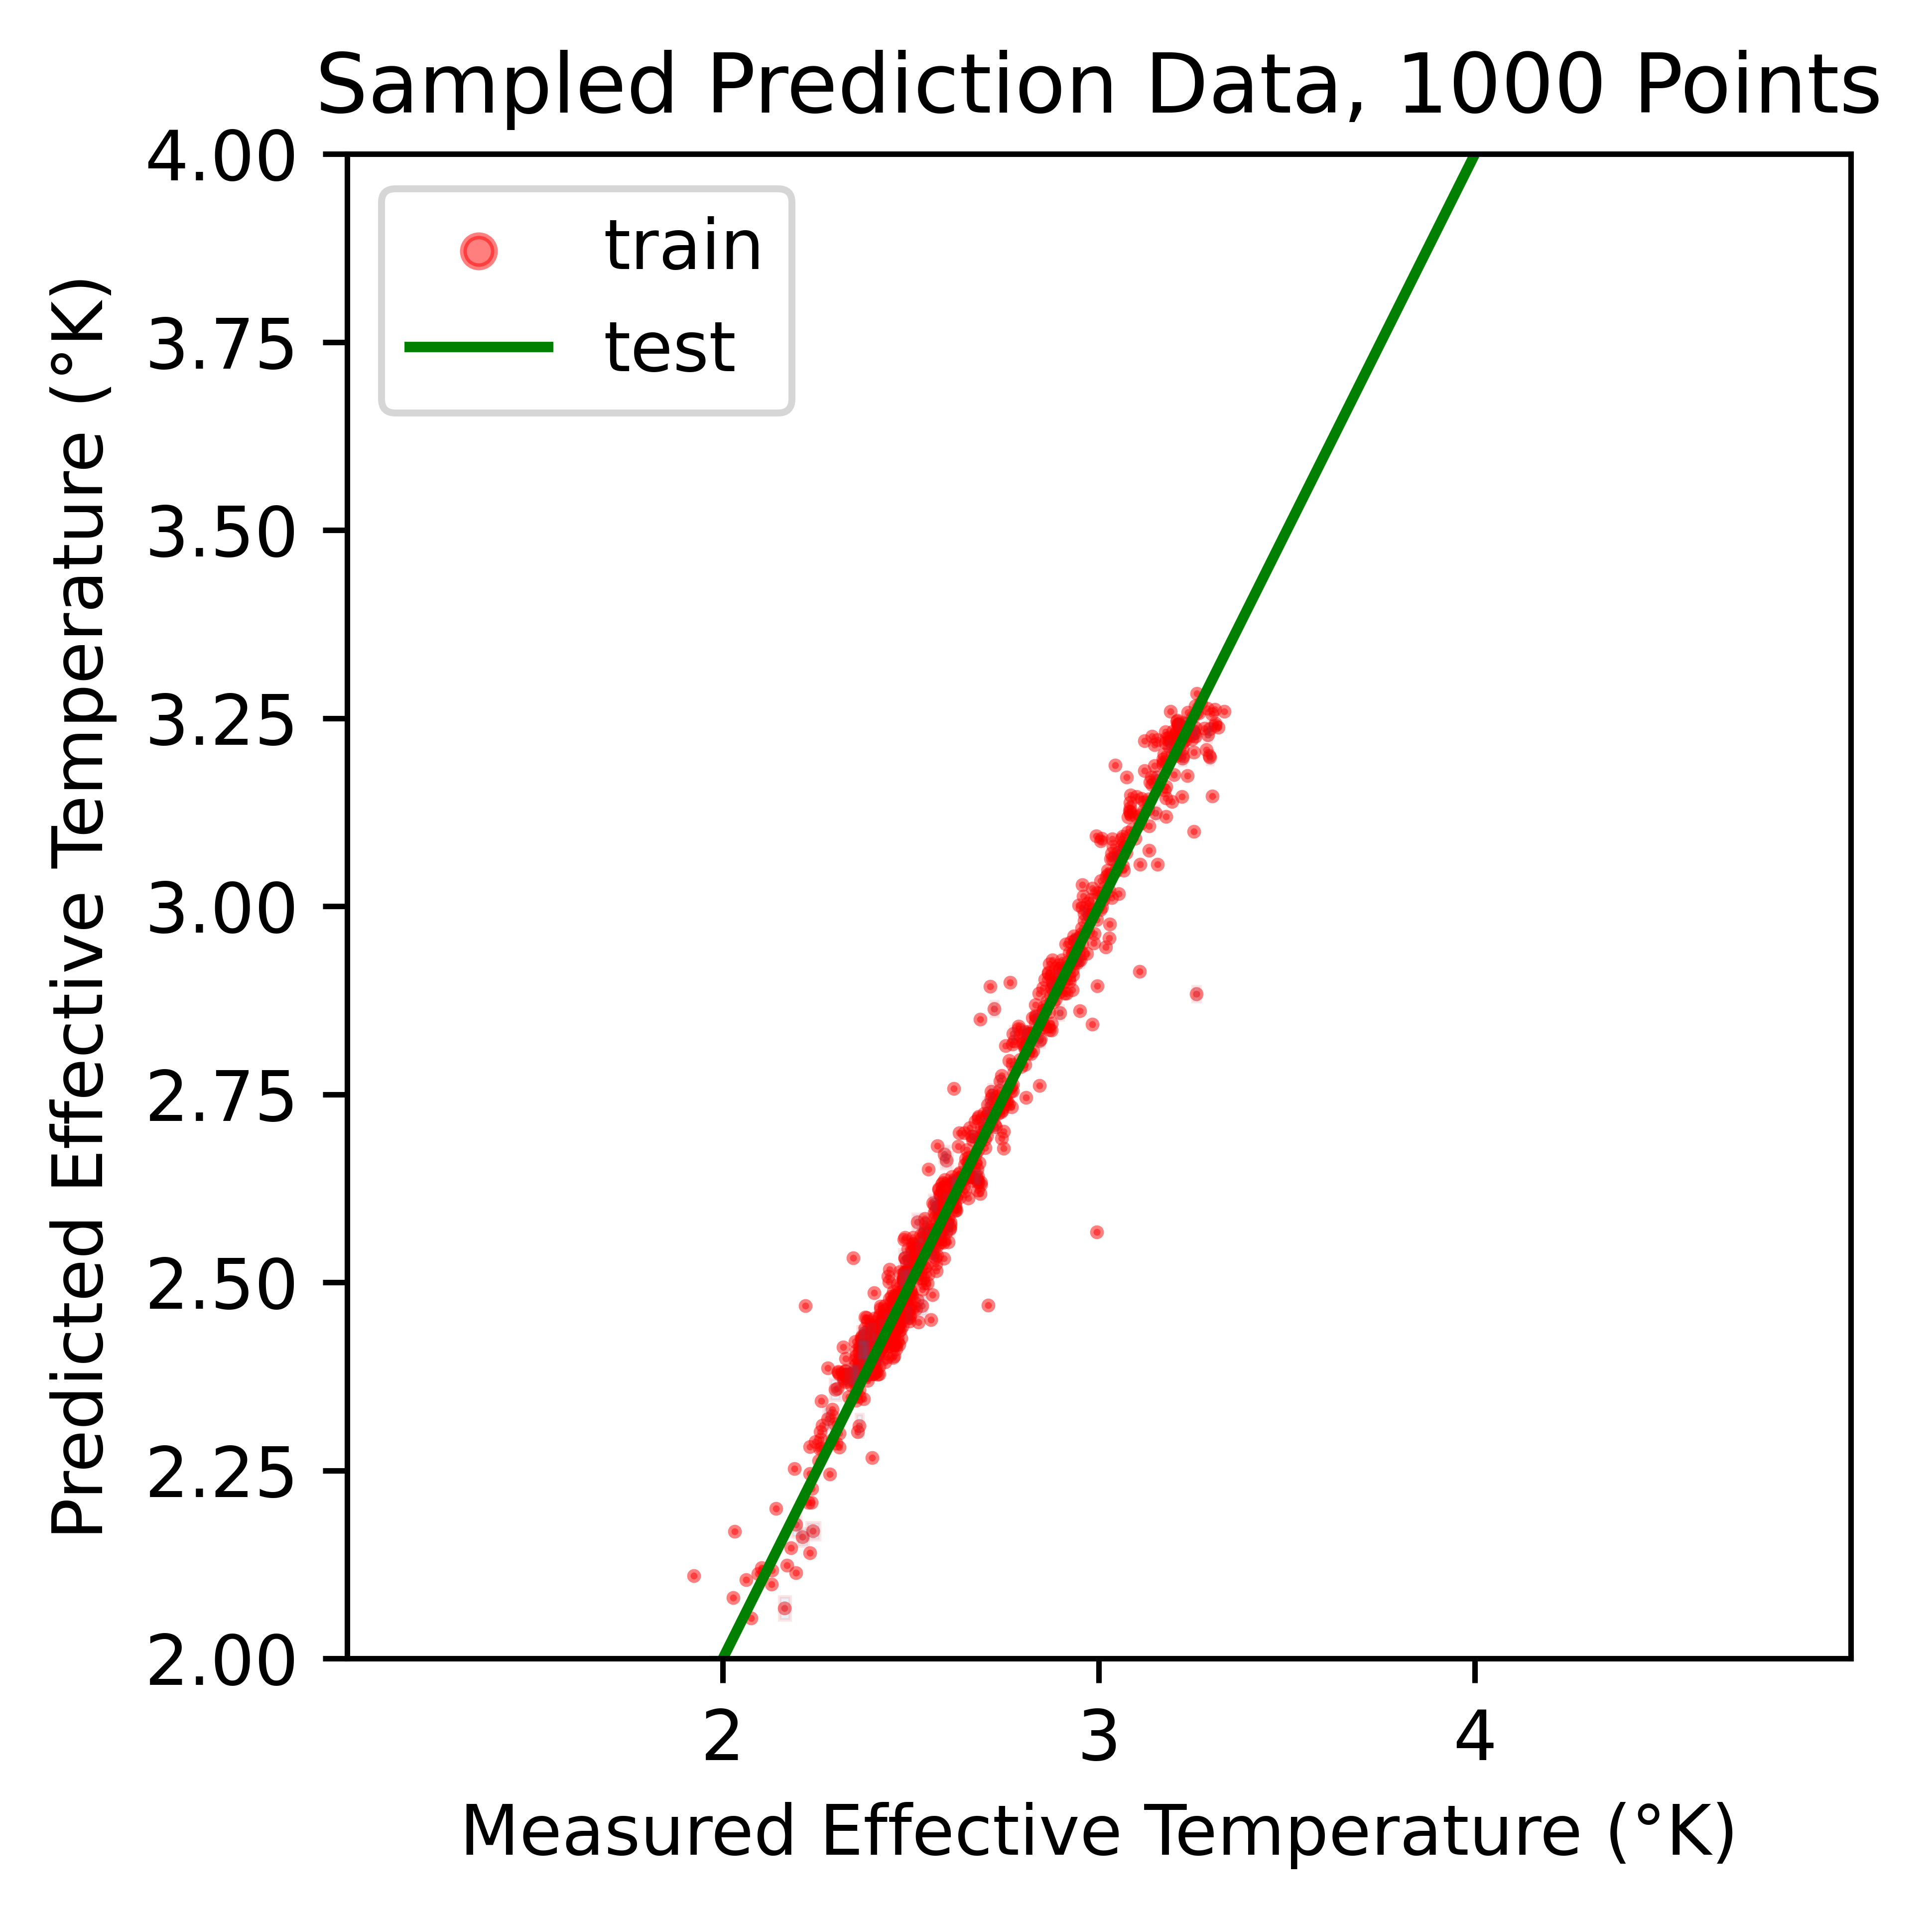

In [26]:
plt.rcParams['figure.dpi'] = 1000
# # plt.figure(figsize = (6.4,4.8))
plt.scatter(train_y[:1000],pred_train_y[:1000], c='red', alpha=0.5,s=1)
# plt.scatter(test_y[:1000],pred_test_y[:1000], c='blue', alpha=0.5,s=0.5)
# plt.hist2d(train_y,pred_train_y,bins=[100,100],cmin=20)
# plt.hist2d(test_y,pred_test_y,bins=[100,100],cmin=20,cmap=plt.cm.BuPu)


# plt.scatter(rand_y,pred_rand_y, c='orange', alpha=0.5,s=0.1)

# bot = 4000
# top = 6000
bot = 2
top = 4

linex = np.linspace(bot-500, top+500)
liney = linex
lineytop = linex*1.06
lineybot = linex*0.94
lineytop2 = linex+200
lineybot2 = linex-200
# Create the plot
plt.plot(linex, liney,c="green",label="±0")
# plt.plot(linex, lineytop,c="red",label="+6%")
# plt.plot(linex, lineybot,c="red",label="-6%")
plt.plot(linex, lineytop2,c="orange",label="+200")
plt.plot(linex, lineybot2,c="orange",label="-200")
labelLines(plt.gca().get_lines(), zorder=2.5)

for i in range(100):
    plt.gca().add_patch(Rectangle((train_y[i] - train_y_err[i],pred_train_y[i] - pred_train_y_err[i]),2 * train_y_err[i],2 * pred_train_y_err[i],fill=True,edgecolor='red',linewidth=0.5,alpha=0.1))

plt.xlim(bot-0.999, top+0.999)
plt.ylim(bot, top)
plt.gca().set_aspect(2, adjustable='box')
plt.title('Sampled Prediction Data, 1000 Points')
plt.ylabel('Predicted Effective Temperature (°K)')
plt.xlabel('Measured Effective Temperature (°K)')
lgnd = plt.legend(['train', 'test'], loc='upper left')
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/s3.png')
plt.show()


In [20]:
def normalize1D(data):
    return np.divide(np.nan_to_num(data,np.nanmean(data)),np.nanmax(data))

In [45]:
mse = mean_squared_error(normalize1D(test_y),normalize1D(pred_test_y),squared=False)
mae = mean_absolute_error(normalize1D(test_y),normalize1D(pred_test_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.042061336 0.035087403


In [46]:
mse = mean_squared_error(test_y,pred_test_y,squared=False)
mae = mean_absolute_error(test_y,pred_test_y)
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
180.27063 138.35678


In [47]:
mse = mean_squared_error(normalize1D(train_y),normalize1D(pred_train_y),squared=False)
mae = mean_absolute_error(normalize1D(train_y),normalize1D(pred_train_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.058655348 0.053131647


In [48]:
mse = mean_squared_error(train_y,pred_train_y,squared=False)
mae = mean_absolute_error(train_y,pred_train_y)
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
167.28917 130.29994


In [ ]:
mse = mean_squared_error(normalize1D(rand_y),normalize1D(pred_rand_y),squared=False)
mae = mean_absolute_error(normalize1D(rand_y),normalize1D(pred_rand_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

NameError: name 'pred_rand_y' is not defined

In [ ]:
mse = mean_squared_error(rand_y,pred_rand_y,squared=False)
mae = mean_absolute_error(rand_y,pred_rand_y)
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

NameError: name 'pred_rand_y' is not defined

In [26]:
errormargin = 0.03
test_count = 0
for i in range(len(normalize1D(test_y))):
    if test_y[i]*(1-errormargin) <= pred_train_y[i] <= test_y[i]*(1+errormargin):
        test_count+= 1
train_count = 0
for i in range(len(normalize1D(train_y))):
    if train_y[i]*(1-errormargin) <= pred_train_y[i] <= train_y[i]*(1+errormargin):
        train_count+= 1
rand_count = 0
for i in range(len(normalize1D(rand_y))):
    if rand_y[i]*(1-errormargin) <= pred_rand_y[i] <= rand_y[i]*(1+errormargin):
        rand_count+= 1

print(test_count,len(test_y),train_count,len(train_y),rand_count,len(rand_y))
print(test_count/len(test_y),train_count/len(train_y),rand_count/len(rand_y))

NameError: name 'pred_rand_y' is not defined

In [27]:
errormargin = 200
test_count = 0
for i in range(len(normalize1D(test_y))):
    if test_y[i]-errormargin <= pred_train_y[i] <= test_y[i]+errormargin:
        test_count+= 1
train_count = 0
for i in range(len(normalize1D(train_y))):
    if train_y[i]-errormargin <= pred_train_y[i] <= train_y[i]+errormargin:
        train_count+= 1
# rand_count = 0
# for i in range(len(normalize1D(rand_y))):
#     if rand_y[i]-errormargin <= pred_rand_y[i] <= rand_y[i]+errormargin:
#         rand_count+= 1

print(test_count,len(test_y),train_count,len(train_y))
print(test_count/len(test_y),train_count/len(train_y))

24711 42989 132929 171953
0.5748214659564075 0.7730542648281797


In [22]:
def overlap(start1, end1, start2, end2):
    """how much does the range (start1, end1) overlap with (start2, end2)"""
    return max(max((end2-start1), 0) - max((end2-end1), 0) - max((start2-start1), 0), 0)

print(overlap(train_y[0]-train_y_err[0],train_y[0]+train_y_err[0],pred_train_y[0]-pred_train_y_err[0],pred_train_y[0]+pred_train_y_err[0]))
print(train_y[7],train_y_err[7],pred_train_y[7],pred_train_y_err[7])

0
3.257 0.006 3.237094 0.009679491


In [27]:
test_count = 0
for i in range(len(normalize1D(test_y))):
    if test_y[i]-200 <= pred_test_y[i] <= test_y[i]+200:
        test_count+= 1
print(test_count,len(test_y))
print(test_count/len(test_y))

test_count = 0
for i in range(len(normalize1D(test_y))):
    if overlap(test_y[i]-test_y_err[i],test_y[i]+test_y_err[i],pred_test_y[i]-pred_test_y_err[i], pred_test_y[i]+pred_test_y_err[i]) > 0:
        test_count+= 1

train_count = 0
for i in range(len(normalize1D(train_y))):
    # print(train_y[i],pred_train_y[i],train_y_err[i],pred_train_y_err[i])
    # print(train_y[i]-train_y_err[i], pred_train_y[i]+pred_train_y_err[i], train_y[i]+train_y_err[i], pred_train_y[i]-pred_train_y_err[i])
    if overlap(train_y[i]-train_y_err[i],train_y[i]+train_y_err[i],pred_train_y[i]-pred_train_y_err[i],pred_train_y[i]+pred_train_y_err[i]) > 0:
        train_count+= 1
print(train_count,len(train_y))
# rand_count = 0
# for i in range(len(normalize1D(rand_y))):
#     if rand_y[i]-errormargin <= pred_rand_y[i] <= rand_y[i]+errormargin:
#         rand_count+= 1

print(test_count,len(test_y),train_count,len(train_y))
print(test_count/len(test_y),train_count/len(train_y))

42989 42989
1.0
82754 171953
20538 42989 82754 171953
0.4777501221242643 0.48125941390961485


# Testing

In [ ]:
float(model.predict(all_data[i][3:121].reshape(-1,118)))

In [ ]:
def testpred_avg(all_data):
    all_y = []
    pred_all_y = []
    kic = all_data[0][0]
    kic_y = []
    for i in range(len(all_data[:10000])):
        kic_y.append(float(model.predict(all_data[i][3:121].reshape(-1,118))))
        if(all_data[i][0]!=kic):
            kic = all_data[i][0]
            all_y.append(all_data[i][1])
            pred_all_y.append(sum(kic_y)/len(kic_y))
            kic_y = []

    return all_y,pred_all_y
all_y,pred_all_y = testpred_avg(all_data)

In [ ]:
plt.scatter(all_y,pred_all_y, c='red', alpha=0.5,s=2)

linex = np.linspace(4000, 6000)
liney = linex
lineytop = linex+200
lineybot = linex-200
lineytop2 = linex*1.03
lineybot2 = linex*0.97
# Create the plot
plt.plot(linex, liney,c="green")
plt.plot(linex, lineytop,c="red")
plt.plot(linex, lineybot,c="red")
plt.plot(linex, lineytop2,c="purple")
plt.plot(linex, lineybot2,c="purple")


plt.xlim(4000, 6000)
plt.ylim(4000, 6000)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/4.2.png')
plt.show()


In [ ]:
mse = np.sqrt(mean_squared_error(normalize1D(all_y),normalize1D(pred_all_y)))
mae = mean_absolute_error(normalize1D(all_y),normalize1D(pred_all_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)